In [1]:
import pandas as pd
import numpy as np
import urllib.request
import datetime
from os.path import join
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpltPath
from shapely.geometry import Polygon
from collections import Counter
from scipy.ndimage.filters import gaussian_filter
import scipy
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
sns.set(font_scale = 2)

In [134]:
base_path = '/glade/work/cbecker/HWT_postproc/20211014/'
model_preds, obs = {}, {}

model_preds['CNN_HRRR'] = xr.open_dataset(join(base_path, 'cnn_test_000_HRRR_1d_predictions.nc'))
model_preds['CNN_WRF'] = xr.open_dataset(join(base_path, 'cnn_test_000_WRF_1d_predictions.nc'))
model_preds['GMM_HRRR'] = xr.open_dataset(join(base_path, 'mod_0_HRRR_1d_predictions.nc'))
model_preds['GMM_WRF'] = xr.open_dataset(join(base_path, 'mod_0_WRF_1d_predictions.nc'))

obs['storm_reports'] = xr.open_dataset(join(base_path, 'gridded_storm_reports.nc'))
obs['HRRR_proxy'] = xr.open_dataset(join(base_path, 'HRRR_proxy_events.nc'))
obs['WRF_proxy'] = xr.open_dataset(join(base_path, 'WRF_proxy_events.nc'))

In [3]:
def hazard_cond_prob(obs, preds, A, B, nprob_thresh=0.0, secondary_thresh=None):
    """
    Args:
        obs: SPC Observations array
        preds: HWT mode predictions array
        A: SPC Hazard ('Torn', 'Hail', 'Wind')
        B: Condition - Storm Mode prediction ('Supercell', 'QLCS', 'Disorganized')
        nprob_thresh: Threshold of neighborhood probability (used as lower threshold when binning)
        secondary_thresh: Upper threshhold for binning (default None)
    Returns: Conditional probability: P(A|B)
    """  
    if secondary_thresh is not None:
        arr = np.where((preds[f'{B}_nprob'] > nprob_thresh).values & (preds[f'{B}_nprob'] <= secondary_thresh).values, 1, 0)
        hits = np.where((arr >= 1) & (obs[A].values >= 1), 1, 0).sum()
        mode_bin = np.where(arr >= 1, 1, 0).sum()

    else:
        hits = np.where((preds[f'{B}_nprob'] > nprob_thresh).values & (obs[A] >= 1).values, 1, 0).sum()
        mode_bin = np.where(preds[f'{B}_nprob'] > nprob_thresh, 1, 0).sum()

    
    cond_prob = hits / mode_bin
    
    return cond_prob

In [4]:
cols = ['ML Model', 'Physical Model', 'Storm Mode', 'Hazard', 'Cond Prob']
df = pd.DataFrame(columns=cols)
i=0

for physical_model in ['WRF', 'HRRR']:
    for ML_model in ['CNN', 'GMM']:
        for hazard in ['torn', 'hail', 'wind']:
            for mode in ['Supercell', 'QLCS', 'Disorganized']:
                cp = hazard_cond_prob(obs['storm_reports'], model_preds[f'{ML_model}_{physical_model}'], hazard, mode, 0.0)
                df.loc[i] = [ML_model, physical_model, mode, hazard, cp]
                i += 1
                
wrf_cnn = df[(df['ML Model'] == 'CNN') & (df['Physical Model'] == 'WRF')]
hrrr_cnn = df[(df['ML Model'] == 'CNN') & (df['Physical Model'] == 'HRRR')]
wrf_gmm = df[(df['ML Model'] == 'GMM') & (df['Physical Model'] == 'WRF')]
hrrr_gmm = df[(df['ML Model'] == 'GMM') & (df['Physical Model'] == 'HRRR')]

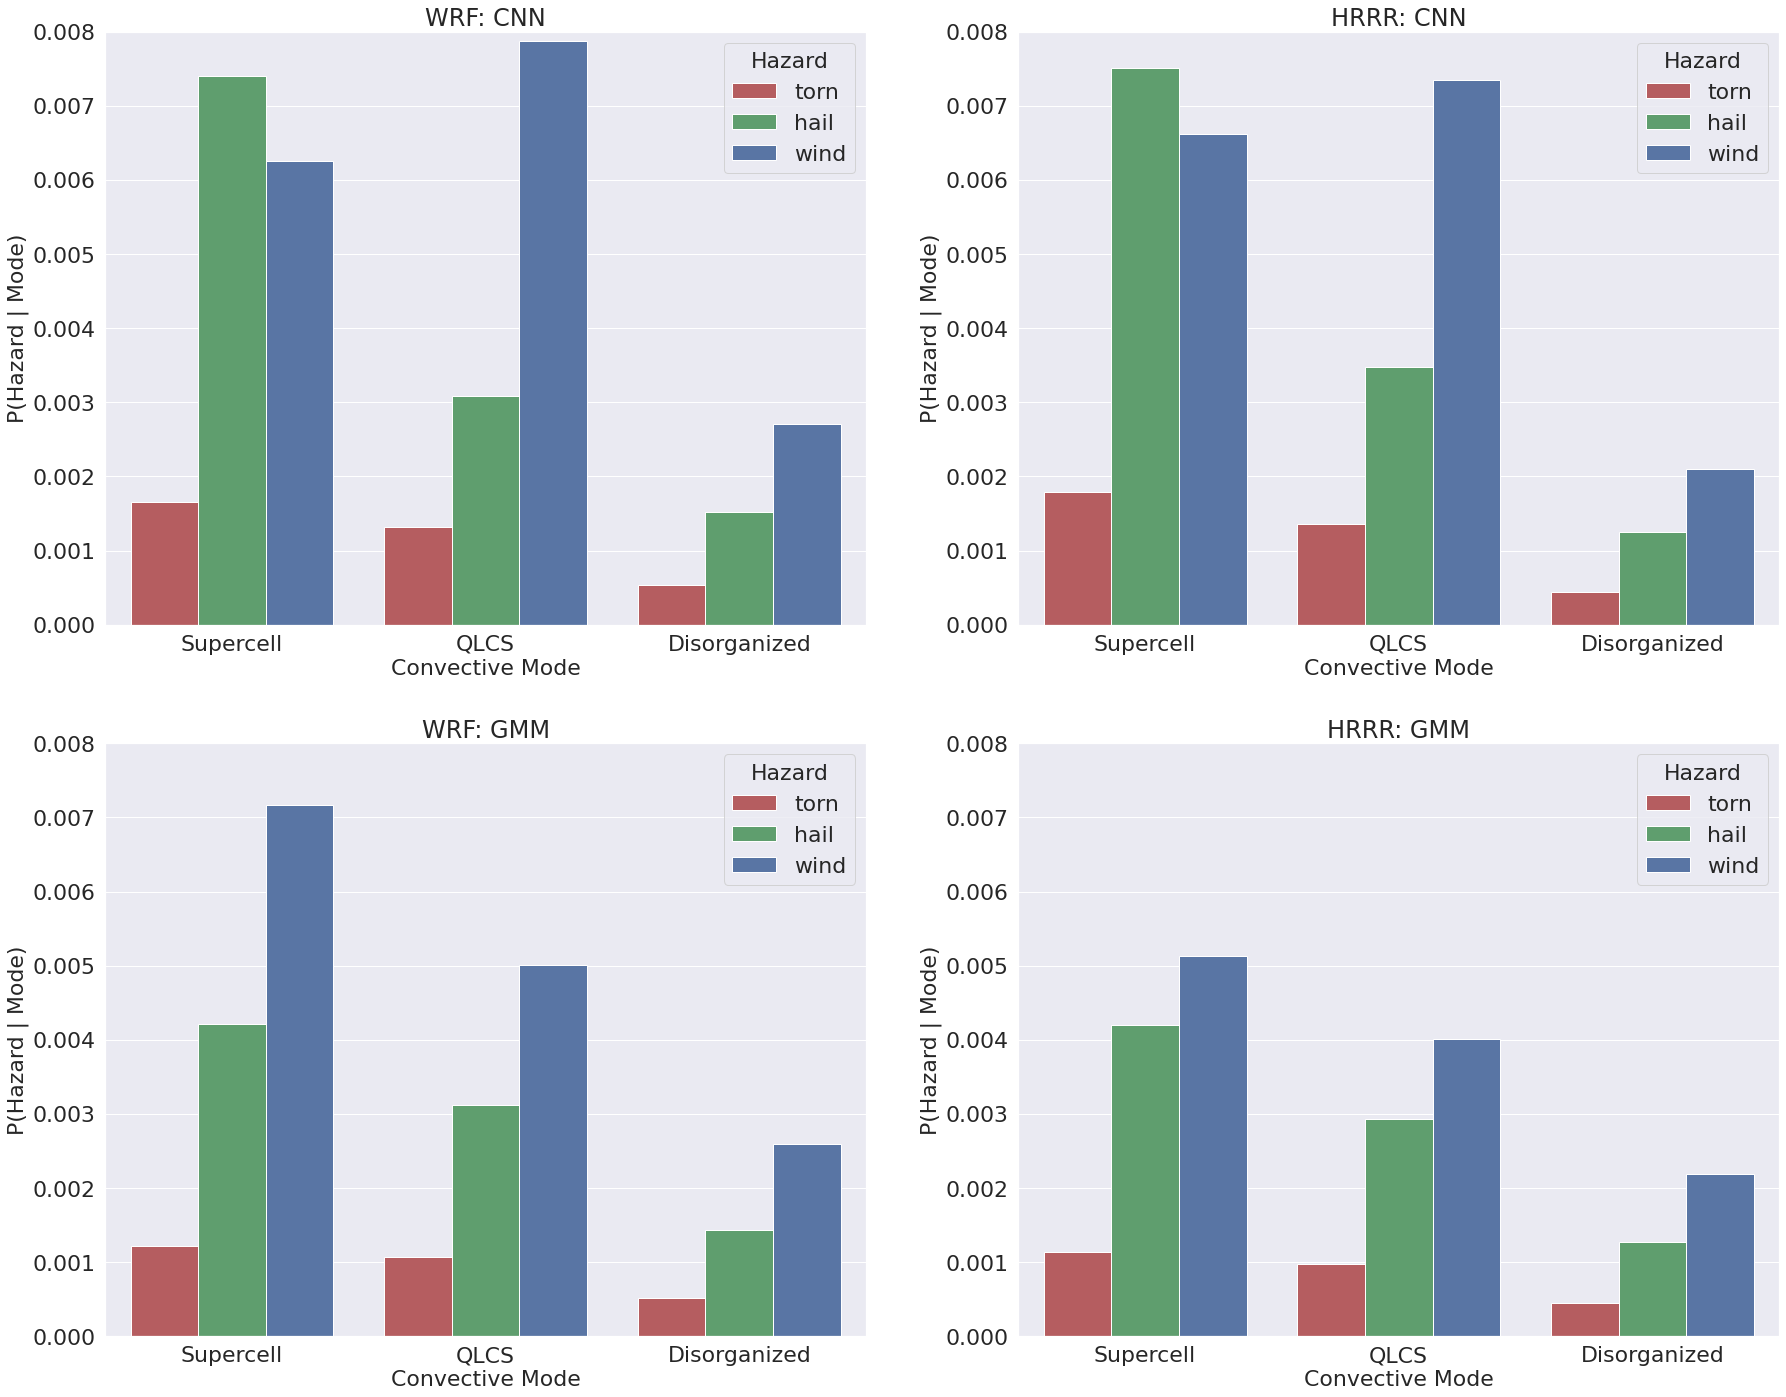

In [5]:
all_data = [wrf_cnn, hrrr_cnn, wrf_gmm, hrrr_gmm]
titles = ['WRF: CNN', 'HRRR: CNN', 'WRF: GMM', 'HRRR: GMM']
fig, axes = plt.subplots(2,2, figsize=(30,24))
for i, ax in enumerate(axes.ravel()):
    p = sns.barplot(hue='Hazard', y='Cond Prob', x='Storm Mode', data=all_data[i], palette=['r','g','b'], ax=ax)
    ax.set_ylim(0, 0.008)
    ax.set_title(titles[i], fontsize=24)
    plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize='22')
    ax.set_ylabel('P(Hazard | Mode)', fontsize=22)
    ax.set_xlabel('Convective Mode', fontsize=22)
# plt.suptitle('Conditional Hazard Probabilities', fontsize=34)
# plt.savefig('/glade/work/cbecker/HWT_output/plots/HWT_Conditional_probs.png', dpi=300, bbox_inches='tight')

In [18]:
cols = ['ML Model', 'Physical Model', 'Storm Mode', 'Hazard', 'Cond Prob', 'Neighborhood Prob']
df = pd.DataFrame(columns=cols)
i=0
bin_width = 0.04

for physical_model in ['WRF', 'HRRR']:
    for ML_model in ['CNN', 'GMM']:
        for hazard in ['torn', 'hail', 'wind']:
            for mode in ['Supercell', 'QLCS']:
                for nproby in np.arange(0.0, 0.32, bin_width):
                    cp = hazard_cond_prob(obs['storm_reports'], model_preds[f'{ML_model}_{physical_model}'], hazard, mode, nproby, nproby + bin_width)
                    df.loc[i] = [ML_model, physical_model, mode, hazard, cp, nproby]
                    i += 1
rel_prob = {}
for physical_model in ['WRF', 'HRRR']:
    for ML_model in ['CNN', 'GMM']:
        for hazard in ['torn', 'hail', 'wind']:
            for mode in ['Supercell', 'QLCS']:
                rel_prob[f'{physical_model}_{ML_model}_{hazard}_given_{mode}'] = df[(df['Physical Model'] == physical_model) & (df['ML Model'] == ML_model) & 
                                                                                    (df['Hazard'] == hazard) & (df['Storm Mode'] == mode)]
for k,v in rel_prob.items():
    rel_prob[k]['Cond Prob'].replace(0.0, np.nan, inplace=True) 

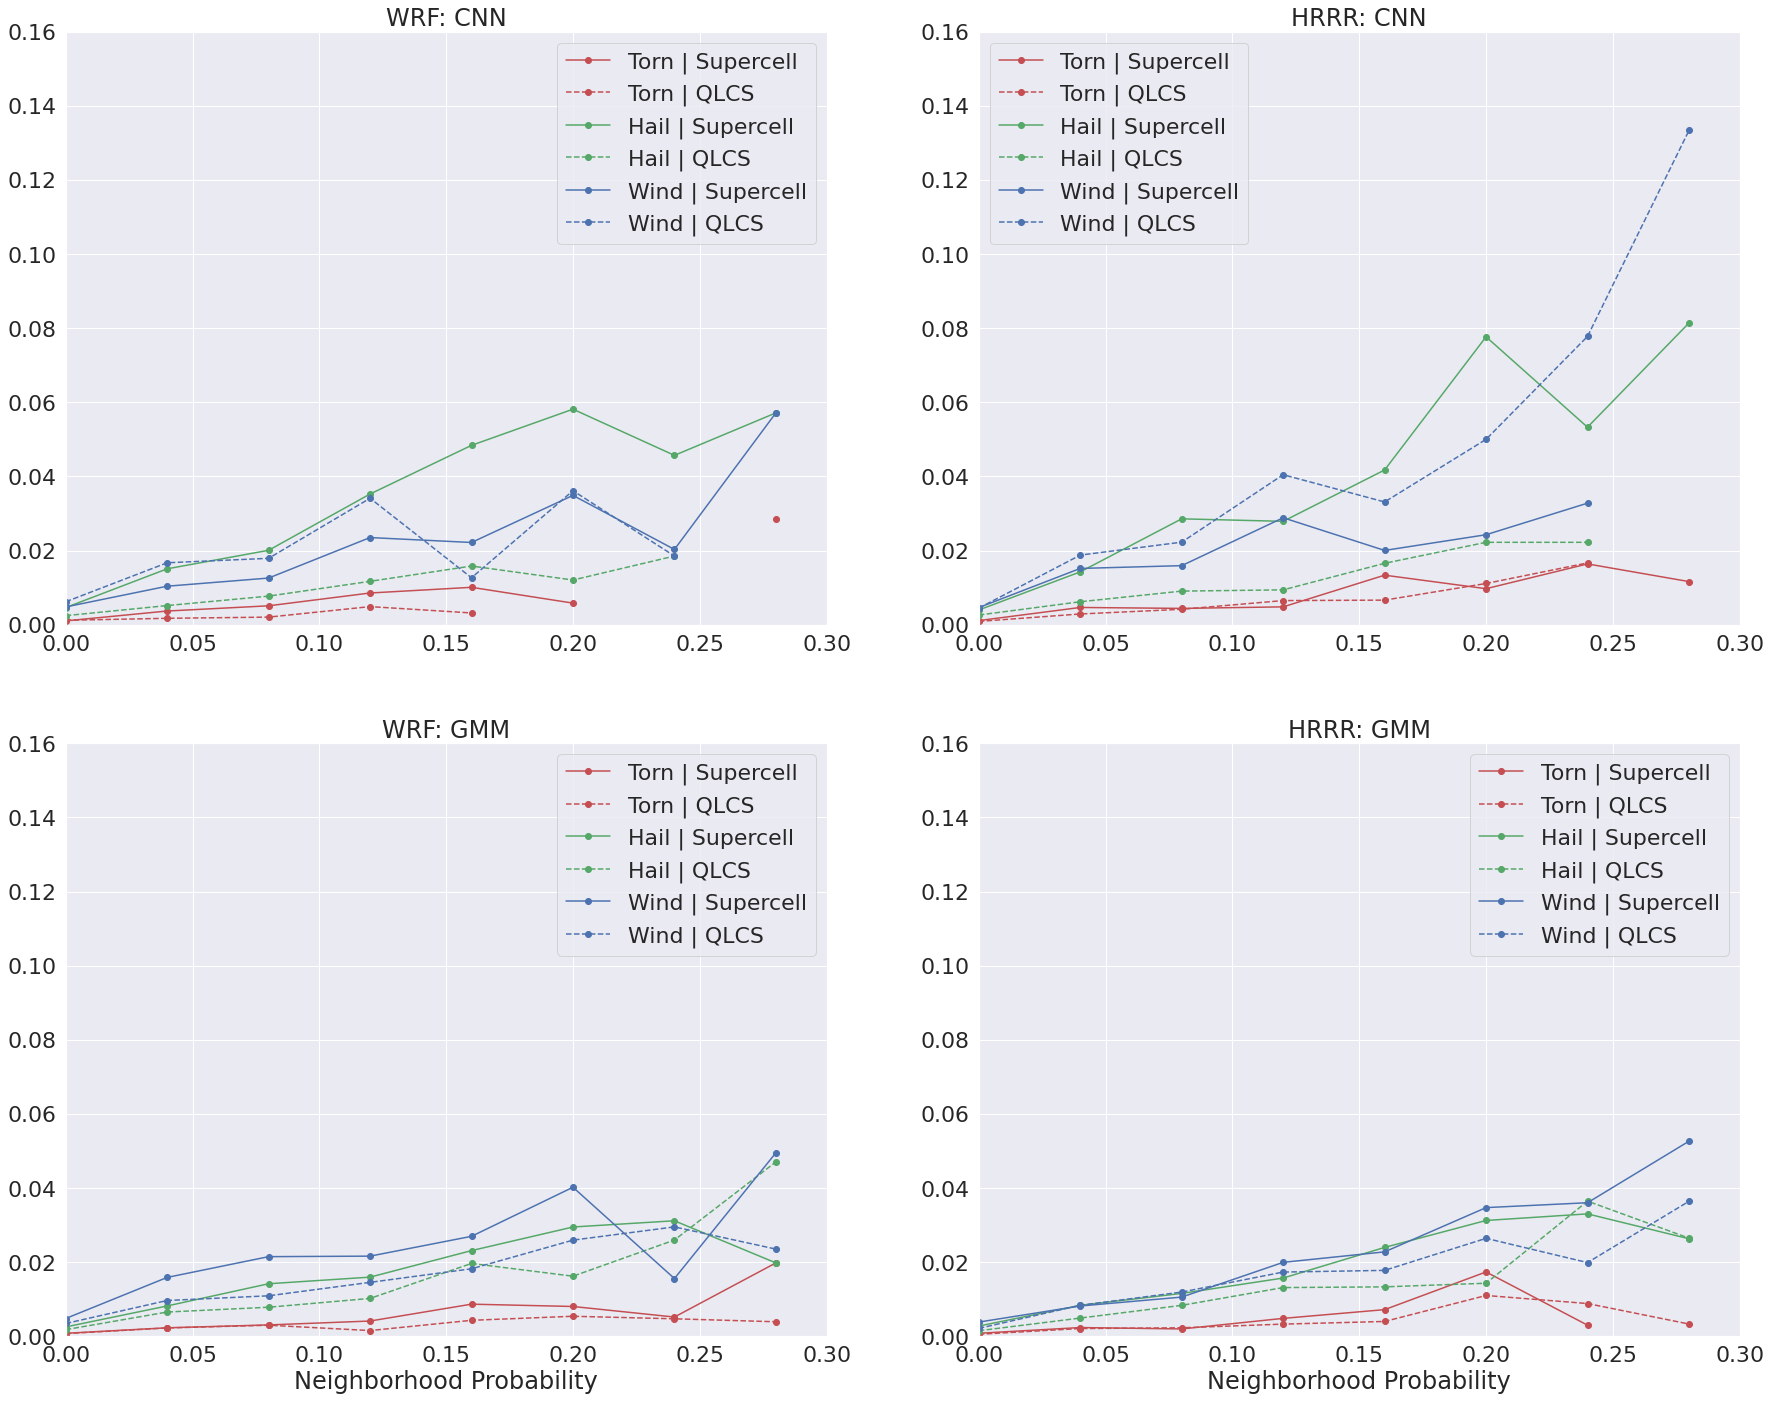

In [19]:
x_labels = ['' , '', 'Neighborhood Probability', 'Neighborhood Probability']
fig, axes = plt.subplots(2,2, figsize=(30,24))
models = ['WRF_CNN', 'HRRR_CNN', 'WRF_GMM', 'HRRR_GMM']
for i, ax in enumerate(axes.ravel()):
    for j, hazard in enumerate(['torn', 'hail', 'wind']):
        for mode in ['Supercell', 'QLCS']:
            if mode == 'Supercell':
                ltype = ['r-o', 'g-o', 'b-o']
            elif mode == 'QLCS':
                ltype = ['r--o', 'g--o', 'b--o']
            df_sub = rel_prob[f'{models[i]}_{hazard}_given_{mode}']
            ax.plot(df_sub['Neighborhood Prob'], df_sub['Cond Prob'], ltype[j], label=f'{hazard.capitalize()} | {mode}')
            ax.set_ylim(0, 0.16)
            ax.set_xlim(0, 0.3)
            ax.set_title(models[i].replace('_', ': '))
            ax.set_xlabel(x_labels[i])
    ax.legend()
# plt.savefig('/glade/work/cbecker/HWT_postproc/20211012/reliabilty_cond_prob_neigh_bin075.png', dpi=300, bbox_inches='tight')

In [21]:
cols = ['ML Model', 'Physical Model', 'Storm Mode', 'Hazard', 'Cond Prob', 'ML Prob']
df = pd.DataFrame(columns=cols)
i=0
bin_width = 10

for physical_model in ['WRF', 'HRRR']:
    for ML_model in ['CNN', 'GMM']:
        for hazard in ['torn', 'hail', 'wind']:
            for mode in ['Supercell', 'QLCS']:
                for ml_bin in np.arange(0, 100, bin_width):
                    cp = hazard_cond_prob(obs['storm_reports'], model_preds[f'{ML_model}_{physical_model}'], hazard, f'{mode}_{ml_bin}_{ml_bin + bin_width}')
                    df.loc[i] = [ML_model, physical_model, mode, hazard, cp, ml_bin]
                    i += 1
                    
rel_prob = {}
for physical_model in ['WRF', 'HRRR']:
    for ML_model in ['CNN', 'GMM']:
        for hazard in ['torn', 'hail', 'wind']:
            for mode in ['Supercell', 'QLCS']:
                rel_prob[f'{physical_model}_{ML_model}_{hazard}_given_{mode}'] = df[(df['Physical Model'] == physical_model) & (df['ML Model'] == ML_model) & 
                                                                                    (df['Hazard'] == hazard) & (df['Storm Mode'] == mode)]
for k,v in rel_prob.items():
    rel_prob[k]['Cond Prob'].replace(0.0, np.nan, inplace=True) 

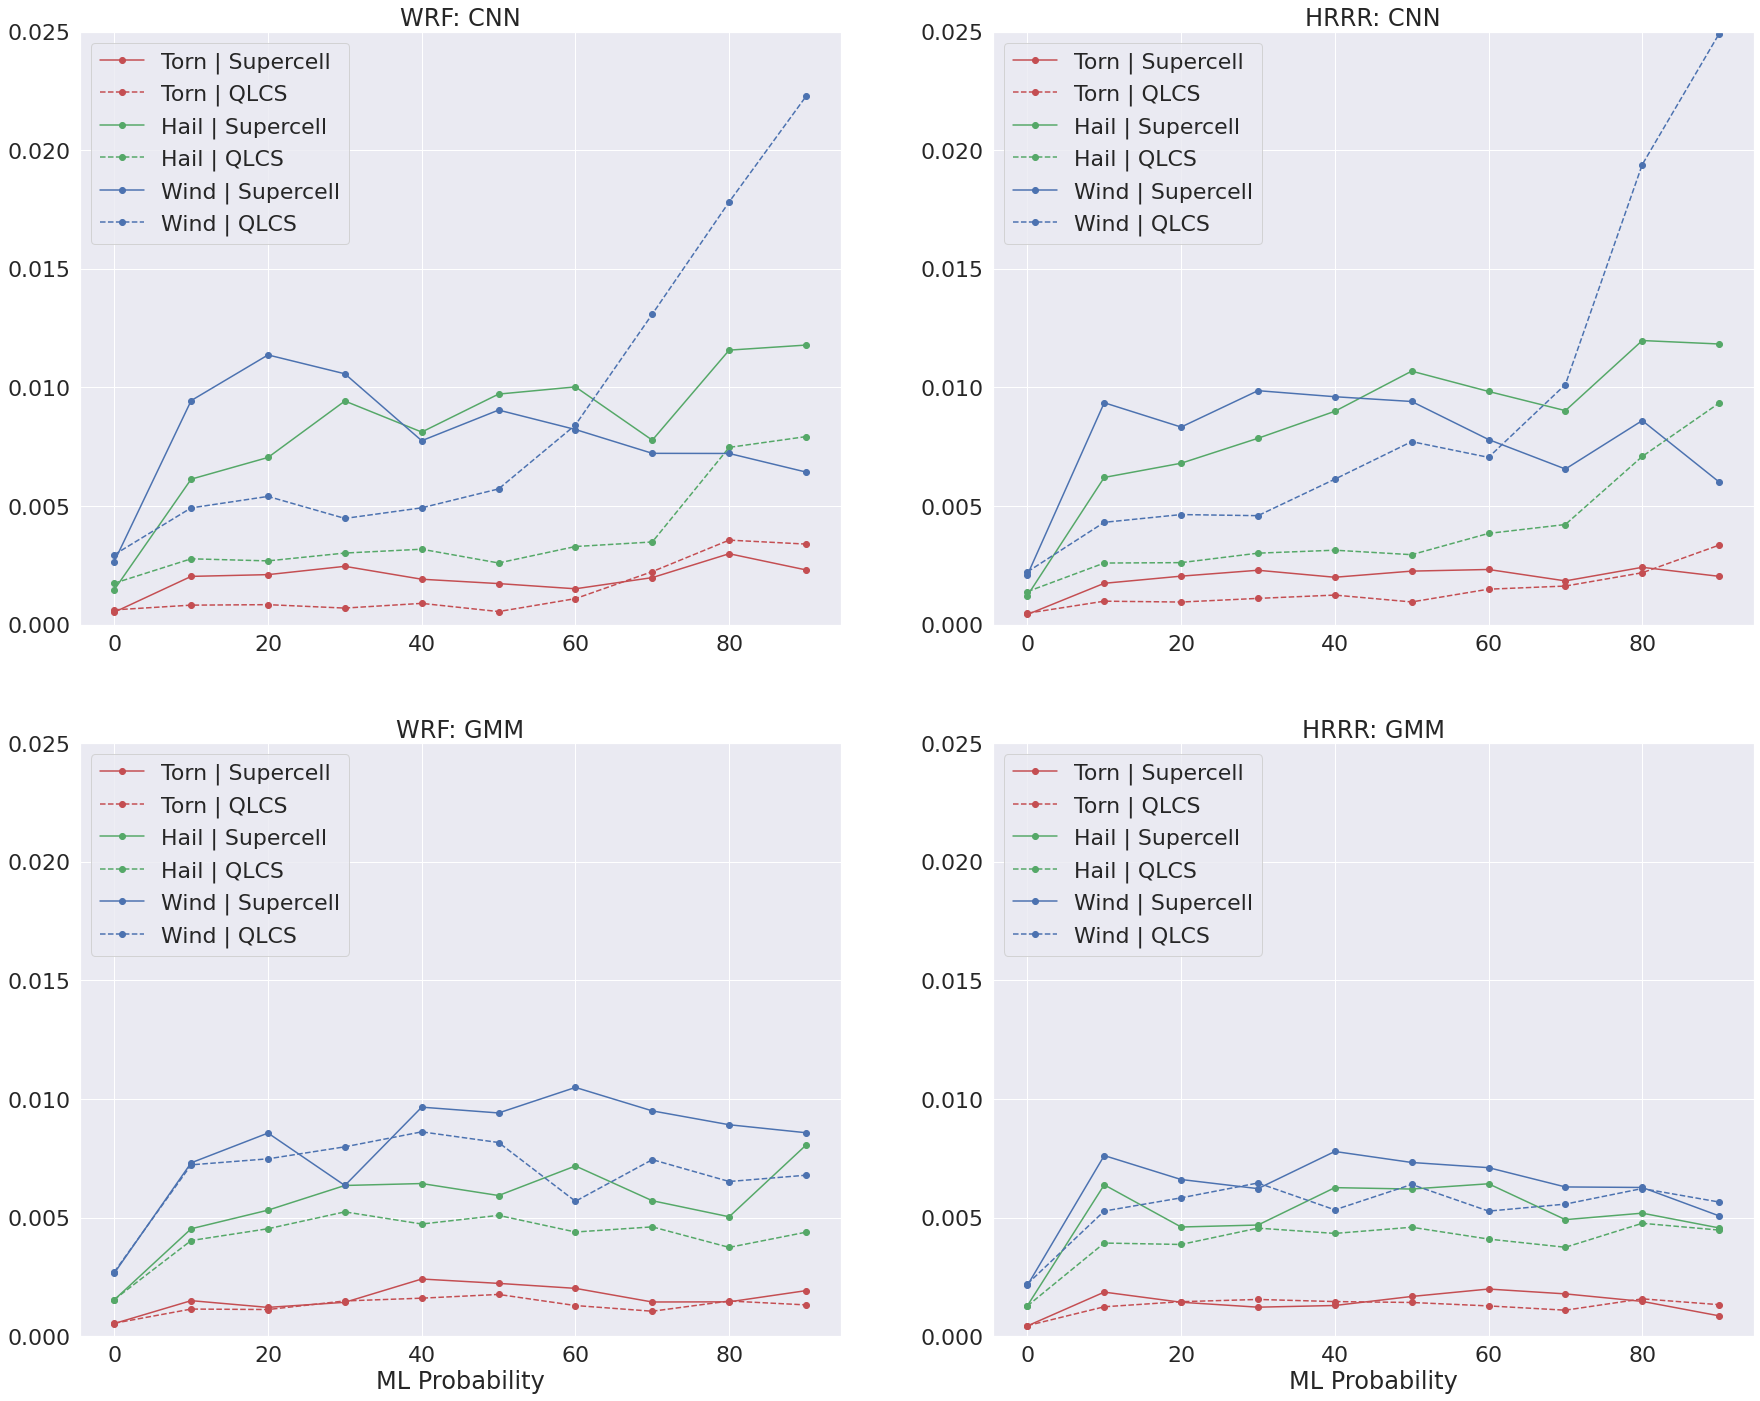

In [22]:
x_labels = ['' , '', 'ML Probability', 'ML Probability']
fig, axes = plt.subplots(2,2, figsize=(30,24))
models = ['WRF_CNN', 'HRRR_CNN', 'WRF_GMM', 'HRRR_GMM']
for i, ax in enumerate(axes.ravel()):
    for j, hazard in enumerate(['torn', 'hail', 'wind']):
        for mode in ['Supercell', 'QLCS']:
            if mode == 'Supercell':
                ltype = ['r-o', 'g-o', 'b-o']
            elif mode == 'QLCS':
                ltype = ['r--o', 'g--o', 'b--o']
            df_sub = rel_prob[f'{models[i]}_{hazard}_given_{mode}']
            ax.plot(df_sub['ML Prob'], df_sub['Cond Prob'], ltype[j], label=f'{hazard.capitalize()} | {mode}')
            ax.set_ylim(0, 0.025)
            ax.set_title(models[i].replace('_', ': '))
            ax.set_xlabel(x_labels[i])
    ax.legend(loc='upper left')
# plt.savefig('/glade/work/cbecker/HWT_postproc/20211012/reliabilty_cond_prob_ML_np02.png', dpi=300, bbox_inches='tight')

In [65]:
pd.read_csv('/glade/work/cbecker/HWT_postproc/20211014/HRRR_proxy_quantile_vals.csv')

,Unnamed: 0,0.99,0.999,0.9999,0.99999,1
0,HAIL_1hr_max_fcst-surface,0.043945,0.064453,0.084697,0.100098,0.114075
1,RELV_1hr_max_fcst-1000_0m_above_ground,0.001442,0.003054,0.005333,0.007858,0.018799
2,WIND_1hr_max_fcst-10m_above_ground,13.476562,16.531250,19.656250,24.125000,46.218750
3,HLCY-1000_0m_above_ground,241.125000,411.500000,590.000000,680.000000,1430.000000
4,HLCY-3000_0m_above_ground,388.250000,731.000000,1110.000000,1400.000000,2120.000000
5,MXUPHL_1hr_max_fcst-3000_0m_above_ground,11.101562,37.000000,74.187500,121.000000,304.000000
6,MNUPHL_1hr_min_fcst-3000_0m_above_ground,0.041504,0.041504,0.041504,0.041504,0.041504


In [66]:
pd.read_csv('/glade/work/cbecker/HWT_postproc/20211014/WRF_proxy_quantile_vals.csv')

,Unnamed: 0,0.99,0.999,0.9999,0.99999,1
0,HAIL_MAXK1,0.000000,0.008667,0.019322,0.038968,0.086873
1,RVORT5_MAX,0.001129,0.002442,0.004210,0.006402,0.026050
2,WSPD10MAX,13.411504,16.892956,20.863630,25.416420,44.722908
3,SRH01,245.924149,437.829627,637.204524,754.892727,1613.466675
4,SRH03,410.710968,775.848230,1259.859688,1663.921220,2780.753418
5,UP_HELI_MIN,0.000000,0.000000,0.000000,0.000000,0.000000
6,UP_HELI_MAX03,0.322765,4.516114,23.318274,63.858795,338.814270


In [111]:
cols = ['ML Model', 'Physical Model', 'Storm Mode', 'Hazard', 'Cond Prob', 'ML Prob']
df = pd.DataFrame(columns=cols)
i=0
bin_width = 10

for physical_model in ['WRF', 'HRRR']:
    for ML_model in ['CNN', 'GMM']:
        if physical_model == 'HRRR':
#             proxy_vars = ['WIND_1hr_max_fcst-10m_above_ground_exceed_0.9999']
            proxy_vars = ['HLCY-1000_0m_above_ground_exceed_0.999', 'HAIL_1hr_max_fcst-surface_exceed_0.99', 'WIND_1hr_max_fcst-10m_above_ground_exceed_0.9999']
        elif physical_model == 'WRF':
#             proxy_vars = ['WSPD10MAX_exceed_0.9999']
            proxy_vars = ['RVORT5_MAX_exceed_0.9999', 'HAIL_MAXK1_exceed_0.9999', 'WSPD10MAX_exceed_0.9999']

        for hazard in proxy_vars:
            for mode in ['Supercell', 'QLCS']:
                for ml_bin in np.arange(0, 100, bin_width):
                    cp = hazard_cond_prob(obs[f'{physical_model}_proxy'], model_preds[f'{ML_model}_{physical_model}'], hazard, f'{mode}_{ml_bin}_{ml_bin + bin_width}')
                    df.loc[i] = [ML_model, physical_model, mode, hazard, cp, ml_bin + bin_width]
                    i += 1
                    
rel_prob = {}
hazards = ['torn proxy', 'hail proxy', 'wind proxy']

for physical_model in ['WRF', 'HRRR']:
    for ML_model in ['CNN', 'GMM']:
        if physical_model == 'HRRR':
#             proxy_vars = ['WIND_1hr_max_fcst-10m_above_ground_exceed_0.9999']
            proxy_vars = ['HLCY-1000_0m_above_ground_exceed_0.999', 'HAIL_1hr_max_fcst-surface_exceed_0.99', 'WIND_1hr_max_fcst-10m_above_ground_exceed_0.9999']
        elif physical_model == 'WRF':
#             proxy_vars = ['WSPD10MAX_exceed_0.9999']
            proxy_vars = ['RVORT5_MAX_exceed_0.9999', 'HAIL_MAXK1_exceed_0.9999', 'WSPD10MAX_exceed_0.9999']
        for i, hazard in enumerate(proxy_vars):
            for mode in ['Supercell', 'QLCS']:
                rel_prob[f'{physical_model}_{ML_model}_{hazards[i]}_given_{mode}'] = df[(df['Physical Model'] == physical_model) & (df['ML Model'] == ML_model) & 
                                                                                    (df['Hazard'] == hazard) & (df['Storm Mode'] == mode)]
for k,v in rel_prob.items():
    rel_prob[k]['Cond Prob'].replace(0.0, np.nan, inplace=True) 

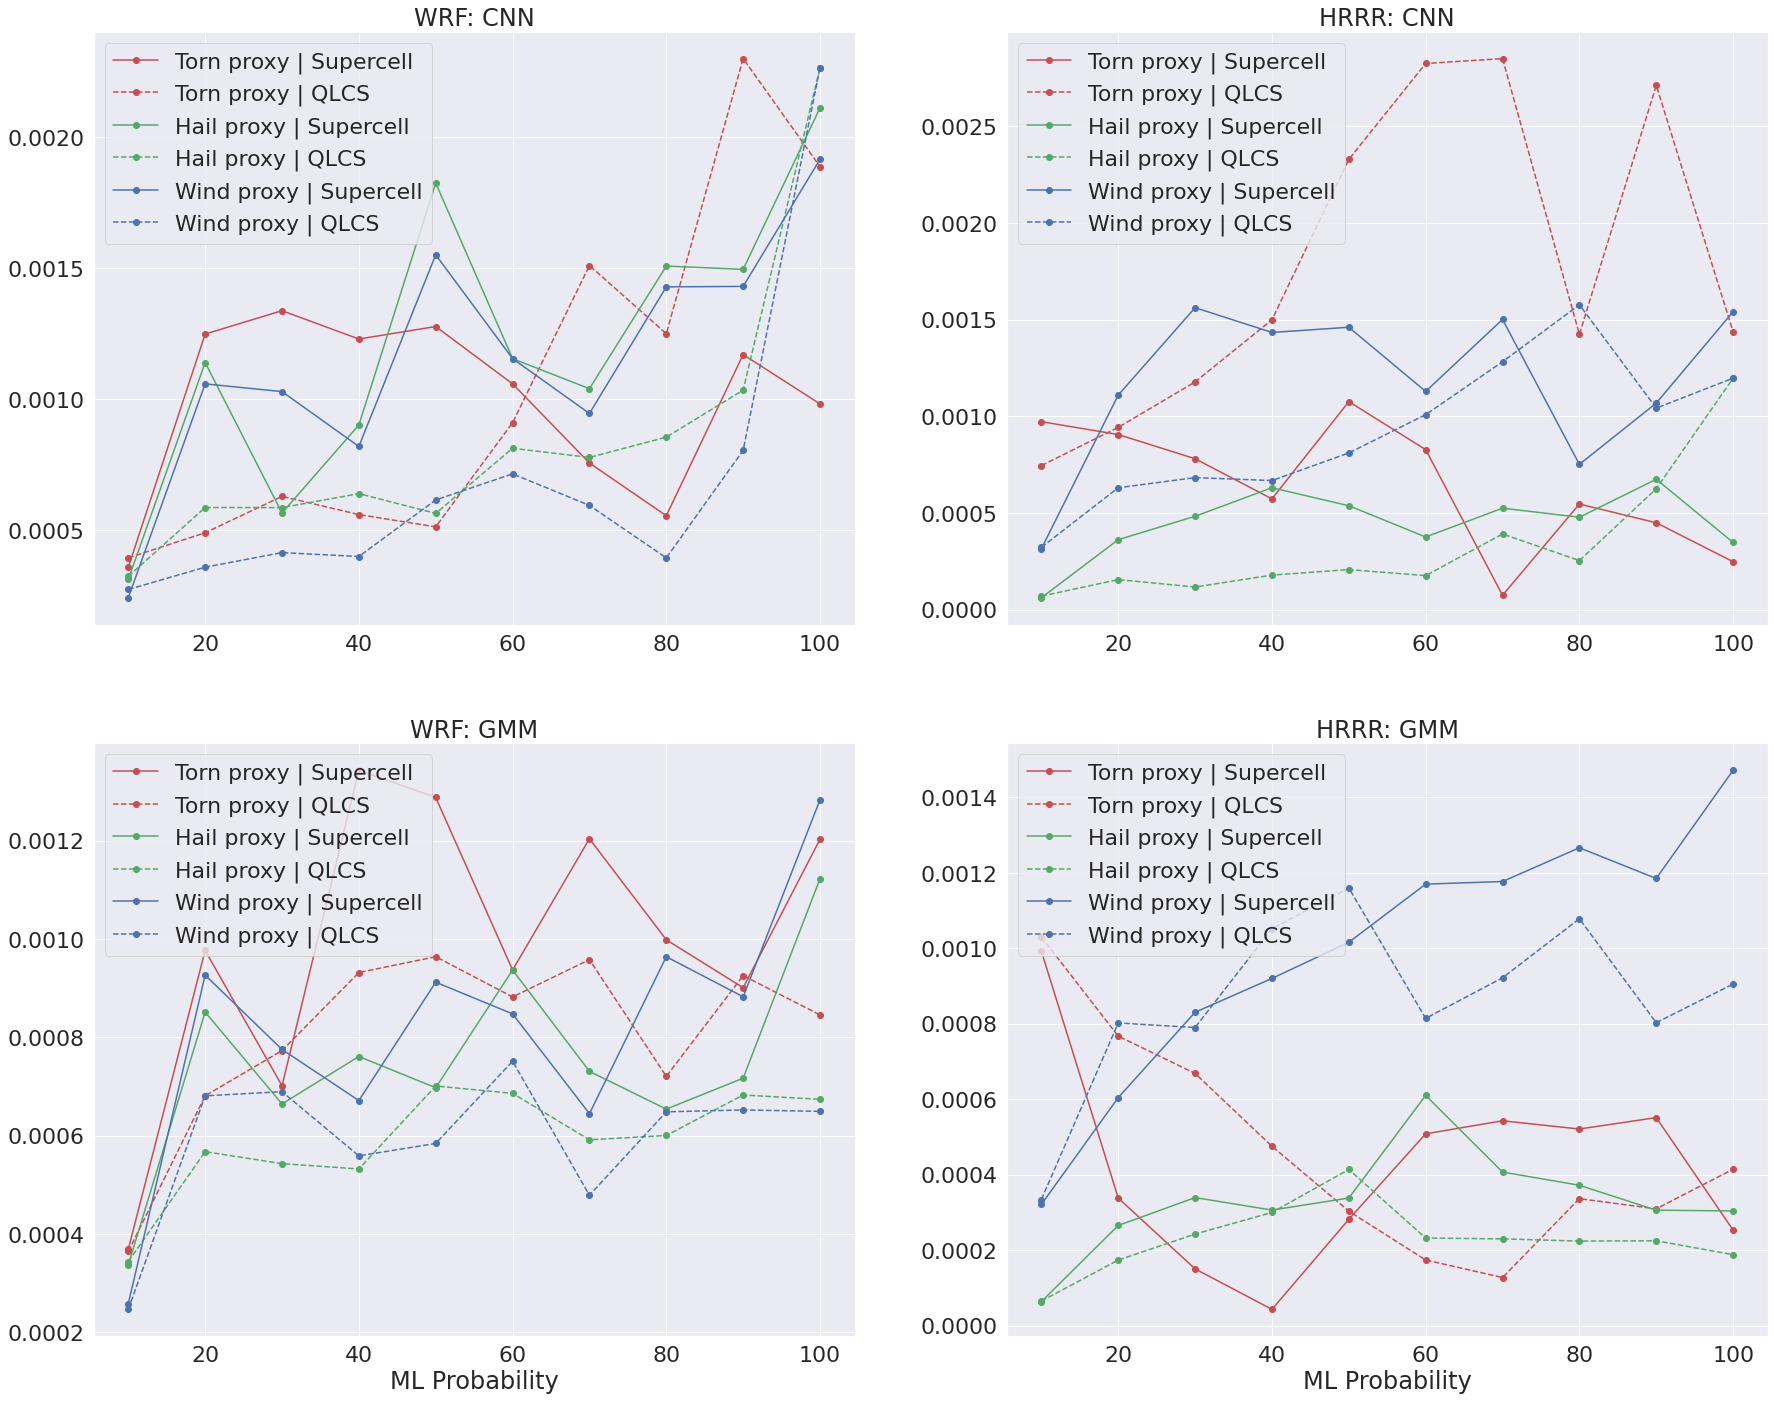

In [112]:
x_labels = ['' , '', 'ML Probability', 'ML Probability']
fig, axes = plt.subplots(2,2, figsize=(30,24))
models = ['WRF_CNN', 'HRRR_CNN', 'WRF_GMM', 'HRRR_GMM']
for i, ax in enumerate(axes.ravel()):
#     for j, hazard in enumerate(['torn', 'hail', 'wind']):
    for j, hazard in enumerate(['torn proxy', 'hail proxy', 'wind proxy']):
        for mode in ['Supercell', 'QLCS']:
            if mode == 'Supercell':
                ltype = ['r-o', 'g-o', 'b-o']
            elif mode == 'QLCS':
                ltype = ['r--o', 'g--o', 'b--o']
            df_sub = rel_prob[f'{models[i]}_{hazard}_given_{mode}']
            ax.plot(df_sub['ML Prob'], df_sub['Cond Prob'], ltype[j], label=f'{hazard.capitalize()} | {mode}')
#             ax.set_ylim(0, 0.5)
            ax.set_title(models[i].replace('_', ': '))
            ax.set_xlabel(x_labels[i])
    ax.legend(loc='upper left')
# plt.savefig('/glade/work/cbecker/HWT_postproc/20211012/reliabilty_cond_prob_ML_np02.png', dpi=300, bbox_inches='tight')

In [128]:
cols = ['ML Model', 'Physical Model', 'Storm Mode', 'Hazard', 'Cond Prob', 'Neighborhood Prob']
df = pd.DataFrame(columns=cols)
i=0
bin_width = 0.04

for physical_model in ['WRF', 'HRRR']:
    for ML_model in ['CNN', 'GMM']:
        if physical_model == 'HRRR':
            proxy_vars = ['HLCY-1000_0m_above_ground_exceed_0.999', 'HAIL_1hr_max_fcst-surface_exceed_0.99', 'WIND_1hr_max_fcst-10m_above_ground_exceed_0.9999']
        elif physical_model == 'WRF':
            proxy_vars = ['RVORT5_MAX_exceed_0.9999', 'HAIL_MAXK1_exceed_0.9999', 'WSPD10MAX_exceed_0.9999']
        for hazard in proxy_vars:
            for mode in ['Supercell', 'QLCS']:
                for nproby in np.arange(0.0, 0.32, bin_width):
                    cp = hazard_cond_prob(obs[f'{physical_model}_proxy'], model_preds[f'{ML_model}_{physical_model}'], hazard, mode, nproby, nproby + bin_width)
                    df.loc[i] = [ML_model, physical_model, mode, hazard, cp, nproby]
                    i += 1
rel_prob = {}
for physical_model in ['WRF', 'HRRR']:
    for ML_model in ['CNN', 'GMM']:
        if physical_model == 'HRRR':
            proxy_vars = ['HLCY-1000_0m_above_ground_exceed_0.999', 'HAIL_1hr_max_fcst-surface_exceed_0.99', 'WIND_1hr_max_fcst-10m_above_ground_exceed_0.9999']
        elif physical_model == 'WRF':
            proxy_vars = ['RVORT5_MAX_exceed_0.9999', 'HAIL_MAXK1_exceed_0.9999', 'WSPD10MAX_exceed_0.9999']
        for i, hazard in enumerate(proxy_vars):
            hazards = ['Torn proxy', 'Hail proxy', 'Wind proxy']
            for mode in ['Supercell', 'QLCS']:
                rel_prob[f'{physical_model}_{ML_model}_{hazards[i]}_given_{mode}'] = df[(df['Physical Model'] == physical_model) & (df['ML Model'] == ML_model) & 
                                                                                    (df['Hazard'] == hazard) & (df['Storm Mode'] == mode)]
for k,v in rel_prob.items():
    rel_prob[k]['Cond Prob'].replace(0.0, np.nan, inplace=True) 

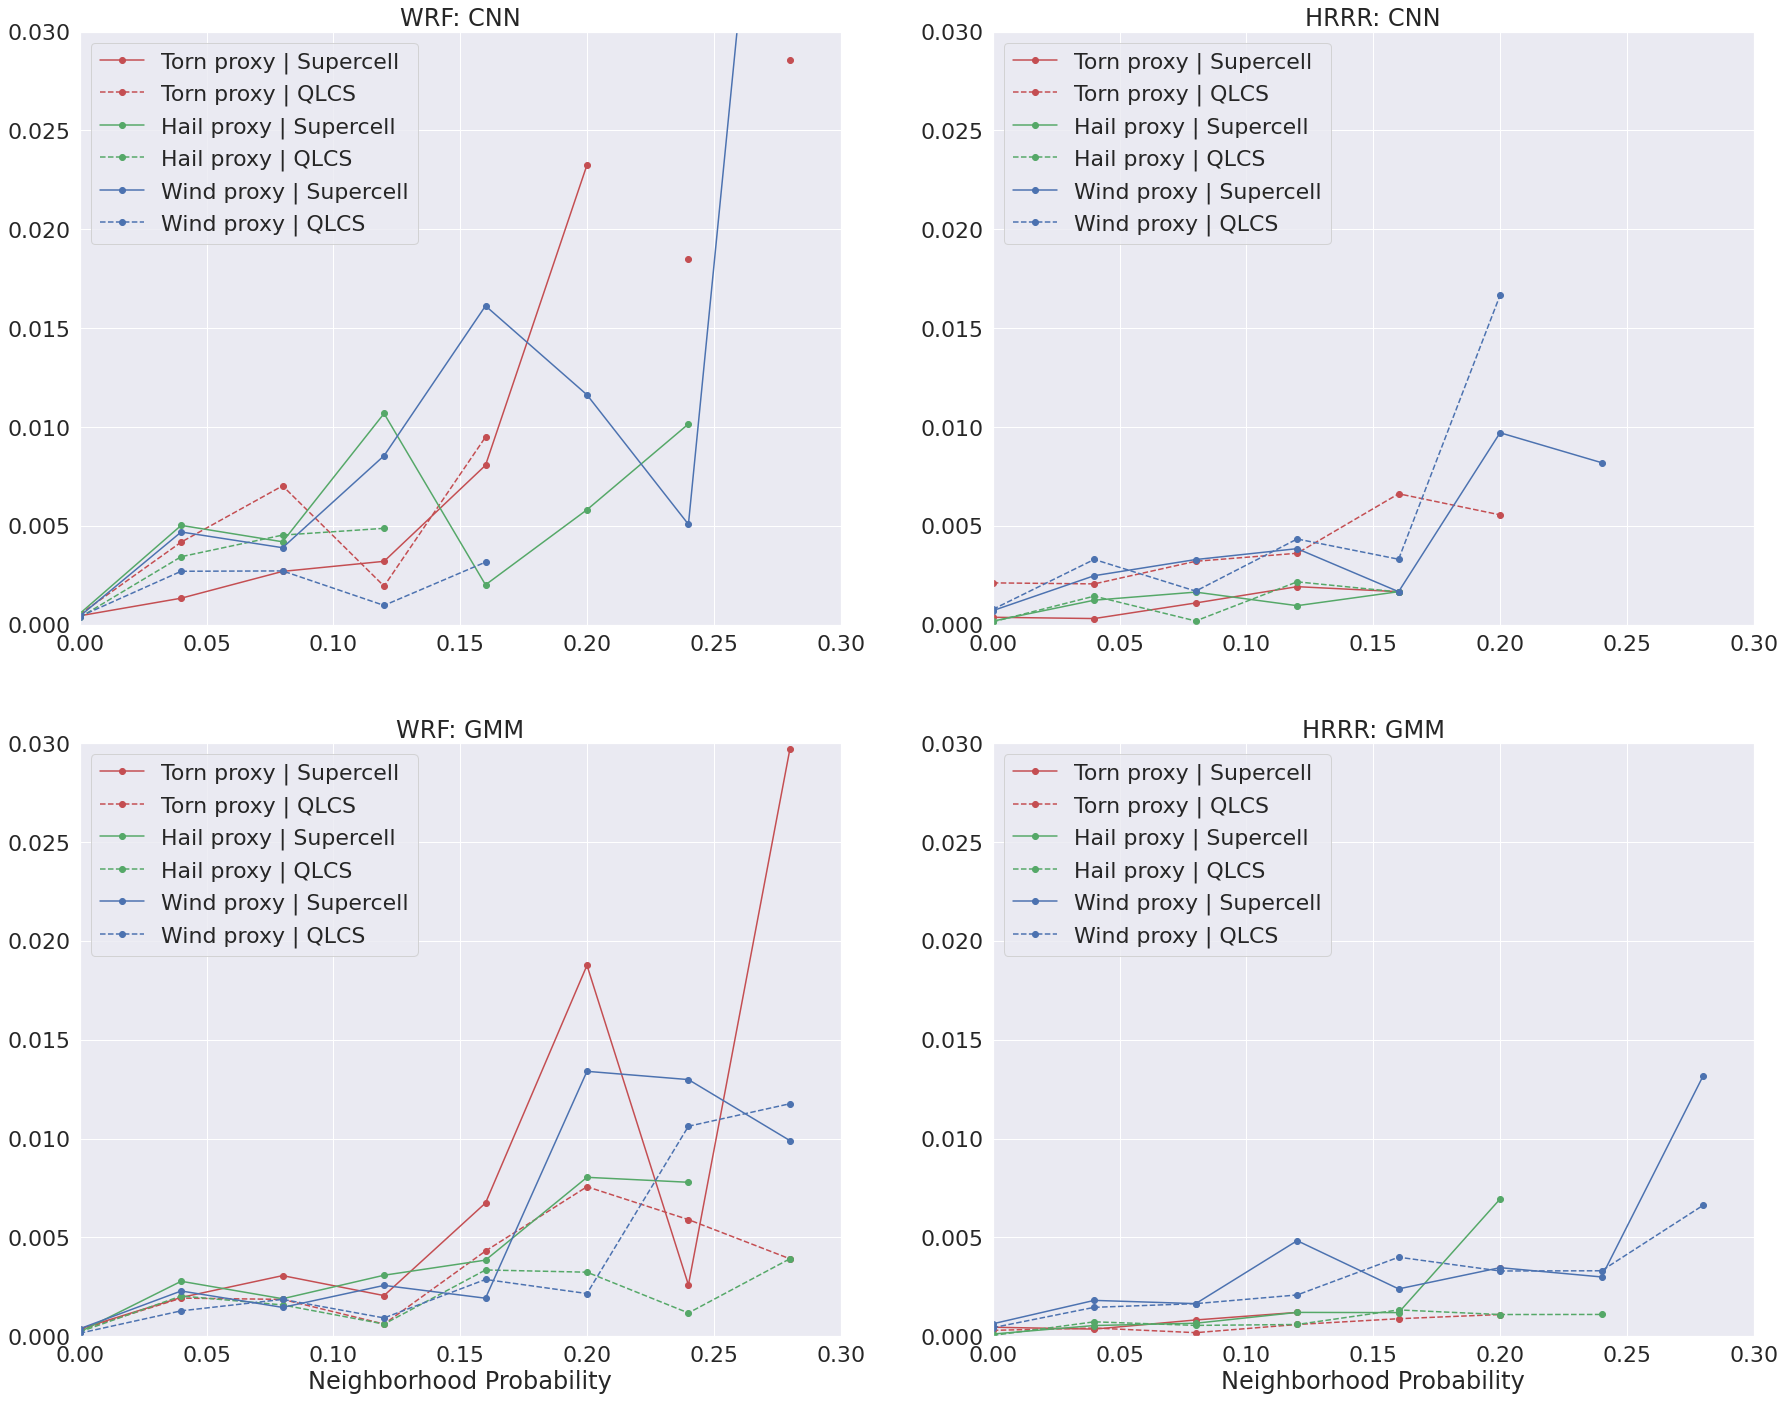

In [133]:
x_labels = ['' , '', 'Neighborhood Probability', 'Neighborhood Probability']
fig, axes = plt.subplots(2,2, figsize=(30,24))
models = ['WRF_CNN', 'HRRR_CNN', 'WRF_GMM', 'HRRR_GMM']
for i, ax in enumerate(axes.ravel()):
    for j, hazard in enumerate(['Torn proxy', 'Hail proxy', 'Wind proxy']):
        for mode in ['Supercell', 'QLCS']:
            if mode == 'Supercell':
                ltype = ['r-o', 'g-o', 'b-o']
            elif mode == 'QLCS':
                ltype = ['r--o', 'g--o', 'b--o']
            df_sub = rel_prob[f'{models[i]}_{hazard}_given_{mode}']
            ax.plot(df_sub['Neighborhood Prob'], df_sub['Cond Prob'], ltype[j], label=f'{hazard.capitalize()} | {mode}')
            ax.set_ylim(0, 0.03)
            ax.set_xlim(0, 0.3)
            ax.set_title(models[i].replace('_', ': '))
            ax.set_xlabel(x_labels[i])
    ax.legend(loc='upper left')
# plt.savefig('/glade/work/cbecker/HWT_postproc/20211012/reliabilty_cond_prob_neigh_bin075.png', dpi=300, bbox_inches='tight')